# Tutorial 5: Define the database tables

### **Requirements:** tutorials 1-5 completed.

This notebook covers the basics of defining tables. In particular, we'll go through:
* Defining a table,
* Defining inheritances and relationships between tables,
* Defining how data is imported into a table, and
* Creating mock-ups of tables before creating them within a database.

All of the tables implemented here are taken from `/src/epiphyte/database/db_setup.py`. Importing this module will directely add these tables to the `epiphyte_mock` database schema. Only the tables that are set up as `Lookup` tables (i.e., draw their entries from a hard-coded source) will be populated upon first import; all others will need to be populated separately. Running the cells with the tables here will have the same effect as importing the module. 

-----------

In [1]:
import numpy as np
from pathlib import Path
from datetime import datetime

from epiphyte.database import config, helpers
from epiphyte.database.access_info import *
from epiphyte.preprocessing.data_preprocessing import data_utils, create_vectors_from_time_points
from epiphyte.preprocessing.annotation.stimulus_driven_annotation.movies import processing_labels
from epiphyte.data.mock_data_utils import *


## 1. Generate the mock data for the example database. 

The following function generates a mock dataset of patient "recordings" during a movie. This mock dataset consists of fake spiking data, local field potential, watchlogs, and annotations to demonstrate the design and population of database tables. 

The generated data is stored in `/epiphyte/data/mock_data/`.

In [ ]:
run_data_generation()

## 2. Identify the order of table population

Since some tables pull information from other tables, we first need to decide on the order of table population. Details of this decision process are given in **§ 4.2.2 Identify a hierarchy**, but ultimately it will depend heavily on the specifics of the dataset. 

In the example dataset, the most top-level information is that which describes a given patient. Each patient comes with the following information: 
* Patient ID number,
* Age of the patient,
* Gender, and
* Year of implantation. 

This information determines the columns of the `Patients` table:

In [ ]:
@epi_schema
class Patients(dj.Lookup):
    definition = """
    # general patient data, imported from config file
    patient_id: int                                    # patient ID
    ---
    age: smallint                                      # age of patient
    gender: enum('f', 'm', 'x')                        # gender of patient
    year: int                                          # year of surgery
    """

    contents = config.patients

Running the ERD should now show a diagram with a single table entity:

In [ ]:
erd = dj.ERD(epi_schema)
erd

We can call the table now and take a look at its contents:

In [ ]:
Patients()

Let's break down each line of the table definition for `Patients`:

```
1   @epi_schema
2   class Patients(dj.Lookup):
3       definition = """
4       # general patient data, imported from config file
5       patient_id: int                                    # patient ID
6       ---
7       age: smallint                                      # age of patient
8       gender: enum('f', 'm', 'x')                        # gender of patient
9       year: int                                          # year of surgery
10      """

11      contents = config.patients
```

1. Class decorator that connects the table to the correct database. You can have an arbitrary number of databases hosted on the same machine -- this line dictates to which schema the table belongs. 
2. Class definition. Here, you name the table (convention is the same as Python class naming), and specify how the table will be populated as the argument input (here, a Lookup table).
3. Docstring specifying the columns of the table. 
4. Description of the table. Notice that this description is printed when the table is called to the notebook above. 
5. Define the primary key of the table. Here, only the patient ID number is needed to uniquely specify a table entry. 
6. Separate the primary from the secondary keys. 
7. Define secondary key, age. 
8. Define secondary key, gender.
9. Define secondary key, year. 
10. Close the table definition docstring. 
11. Link the class to the location from which the contents should be populated. Here, the contents are drawn from a dictionary defined in `/src/epiphyte/database/config.py` as the variable `patients`. Adding a new line here and importing the table again will create the new corresponding row. 

For this experiment and dataset, a patient might run the same paradigm more than once, meaning that there can be more than one experimental session per patient. To represent this in the database, we separate the patient information from the session information by also creating a separate `Sessions` table. 

In [ ]:
@epi_schema
class Sessions(dj.Lookup):
    definition = """
    # general session data, imported from config file
    patient_id: int                                    # patient ID
    session_nr: int                                    # session number
    ---
    session_type: enum('full_movie', 'follow_up', 'partial_movie')   # type of session for corresponding recording
    """

    contents = config.sessions

There are two additional Lookup tables in the database, `Annotators` and `LabelNames`. 
These tables contain the information regarding identity of label creators and the names of the created labels, respectively. 

In [ ]:
@epi_schema
class Annotator(dj.Lookup):
    definition = """
    # annatotors of the video, imported from config file
    annotator_id: varchar(5)                    # unique ID for each annotator
    ---
    first_name: varchar(32)                      # first name of annotator
    last_name: varchar(32)                       # last name of annotator
    """

    contents = config.annotators

@epi_schema
class LabelName(dj.Lookup):
    definition = """
    # names of existing labels, imported from config file
    label_name: varchar(32)   # label name
    """

    contents = config.label_names

Now looking at the entity relationship diagram, we can see 4 tables arranged with a flat hierarchy, since no table depends on another table.

In [ ]:
erd = dj.ERD(epi_schema)
erd

The remaining tables, shown below in a modified Panel B from Figure 3, should be defined and instantiated according to the hierarchy, or "downstream" along the ERD.

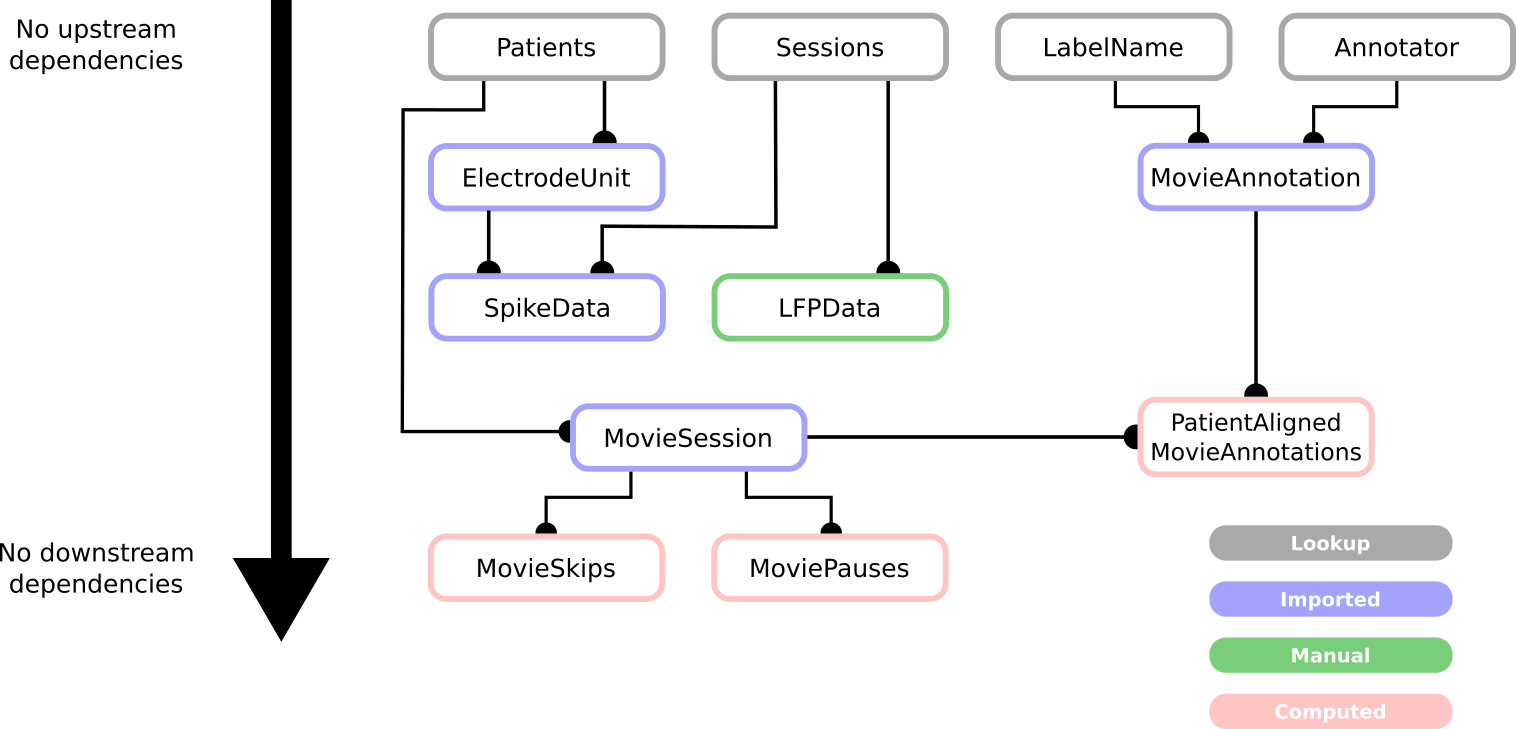

Level I: `Patients`, `Sessions`, `Annotator`, `LabelName`

Level II: `MovieSession`, `ElectrodeUnit`, `LFPData`, `MovieAnnotation`

Level III: `SpikeData`, `PatientAlignedMovieAnnotations`, `MovieSkips`, `MoviePauses`

## 3. Define remaining tables, including dependencies/relationships. 

Now we can start defining the later tables (Level II, Level III).

Technically, you can define all tables at once, and then instantiate and populate them in the correct order. For the sake of this tutorial, we will cover a couple tables from Level II and a couple from Level II, including the table a) definition, b) instantiation (addition of the empty table to the database), and c) population. 

### `MovieSession`

The `MovieSession` table contains the paradigm variables from each patient's movie watch. It takes its primary keys from the `Patients` and `Sessions` tables. Additionally, this table is of type `dj.Imported` and directly pulls its entries from the dataset created in the first tutorial. Since it imports its entries, we will need to additionally define a function for populating the table. Here, we will use the autopopulation method from the Datajoint package (more info [here](https://datajoint.com/docs/core/datajoint-python/0.14/api/datajoint/autopopulate/)).

In [ ]:
@epi_schema
class MovieSession(dj.Imported):
    definition = """
    # data of individual movie watching sessions
    -> Patients                          # patient ID
    -> Sessions                          # session ID
    ---
    date : date                         # date of movie session
    time : time
    pts: longblob                       # order of movie frames for patient (pts) 
    dts: longblob                       # cpu time stamps (dts)
    neural_recording_time: longblob     # neural recording time (rectime)
    channel_names: longblob             # channel name, indicating electrode number and brain region
    """
    
    def _make_tuples(self, key):
        patient_ids = Patients.fetch("patient_id")       

        for _, pat in enumerate(patient_ids):

            pat_sessions = (Sessions & f"patient_id={pat}").fetch("session_nr")       

            try:
                checks = (MovieSession & f"patient_id={pat}").fetch("session_nr")
                if len(checks) == len(pat_sessions):
                    print(checks)
                    print(len(checks), len(pat_sessions))
                    continue
                else:
                    print(f"Adding patient {pat} to database...")
                    pass
            except:
                print(f"Adding patient {pat} to database...")
                pass

            for _, sesh in enumerate(pat_sessions):

                try:
                    check = len((MovieSession & f"patient_id={1}" & f"session_nr={1}").fetch("pts")[0])
                    if check > 0:
                        print(f"Adding patient {pat} to database...")
                        pass
                    else:
                        continue
                except:
                    print(f"Adding patient {pat} to database...")
                    pass

                main_patient_dir = Path(config.PATH_TO_PATIENT_DATA, str(pat), f"session_{sesh}")

                session_info = np.load(main_patient_dir / "session_info.npy", allow_pickle=True)
                date = session_info.item().get("date")
                time = session_info.item().get("time")
                time = datetime.strptime(time, '%H-%M-%S').strftime('%H:%M.%S')

                path_wl =  main_patient_dir / "watchlogs" 
                ffplay_file = next(path_wl.glob("ffplay*"), None)

                if ffplay_file:
                    print(" Found ffplay file:", ffplay_file)
                else:
                    print(" No ffplay file found in the watchlogs directory.")
                    break

                path_daq = main_patient_dir / "daq_files" 
                daq_file = next(path_daq.glob("timedDAQ*"), None)
                
                if ffplay_file:
                    print(" Found DAQ file:", daq_file)
                else:
                    print(" No DAQ file found in the daq_files directory.")
                    break
                    
                path_events = main_patient_dir / "event_file" / "Events.npy"
                time_conversion = data_utils.TimeConversion(path_to_wl=ffplay_file, path_to_dl=daq_file,
                                                                    path_to_events=path_events)
                pts, rectime, dts = time_conversion.convert()
                
                save_dir = main_patient_dir / "movie_info"
                save_dir.mkdir(exist_ok=True)
                np.save(save_dir / "pts.npy", pts)
                np.save(save_dir / "dts.npy", dts)
                np.save(save_dir / "neural_rec_time.npy", rectime)

                path_channel_names = main_patient_dir / "ChannelNames.txt"
                channel_names = helpers.get_channel_names(path_channel_names)

                self.insert1({'patient_id': pat,
                            'session_nr': sesh,
                            'date': date,
                            'time': time,
                            'pts': pts,
                            'dts': dts,
                            'neural_recording_time': rectime,
                            'channel_names': channel_names
                            }, skip_duplicates=True)


TODO 

explain populate method a little bit, with the lfp manual population in mind

In [ ]:
MovieSession.populate()
MovieSession()

In [ ]:
erd = dj.ERD(epi_schema)
erd

### `LFPData`

The `LFPData` 

In [ ]:
@epi_schema
class LFPData(dj.Manual):
    definition = """
    # local field potential data, by channel. 
    -> Patients
    -> Sessions
    csc_nr: int
    ---
    samples: longblob                # samples, in microvolts
    timestamps: longblob             # timestamps corresponding to each sample, in ms
    sample_rate: int                 # sample rate from the recording device
    brain_region: varchar(8)         # brain region where unit was recorded
    """

defining a function for manually adding data to the table


In [ ]:
def populate_lfp_data_table():
    """
    Iterates over the channel files stored in config.PATH_TO_DATA/lfp_data/
    and adds each channel to the table. 

    Ignores channels already uploaded.
    """

    patient_ids, session_nrs = MovieSession.fetch("patient_id", "session_nr")

    for i_pat, pat in enumerate(patient_ids):
        pat_sessions = session_nrs[i_pat]

        for i_sesh, sesh in enumerate(pat_sessions):
         
            path_ds_dir = Path(config.PATH_TO_PATIENT_DATA, str(pat), f"session_{sesh}", "lfp_data")
            lfp_files = list(path_ds_dir.glob("CSC*"))

            try:
                check = (LFPData & f"patient_id={pat}" & f"session_nr={sesh}").fetch("csc_nr")[0]
                if len(check) == len(lfp_files):
                    print(f"    Patient {pat} session {sesh} already added.")
                    continue
                else:
                    print(f"    Adding patient {pat} session {sesh} to database...")
                    pass
            except:
                print(f"    Adding patient {pat} session {sesh} to database...")
                pass

            path_channels = Path(config.PATH_TO_PATIENT_DATA, str(pat), f"session_{sesh}", "ChannelNames.txt")
            channel_names = helpers.get_channel_names(path_channels)

            for ds_file in path_ds_dir.iterdir():
                
                csc_nr = ds_file.name.split('_')[0][3:]
                region = channel_names[int(csc_nr)-1]
                print(f"  .. adding csc {csc_nr}..")
                ds_dict = np.load(ds_file, allow_pickle=True)
                LFPData.insert1({
                    'patient_id': pat,
                    'session_nr': sesh,
                    'csc_nr': csc_nr,
                    'samples': ds_dict.item().get("samples"),
                    'timestamps': ds_dict.item().get("timestamps"),
                    'sample_rate': ds_dict.item().get("sample_rate")[0],
                    'brain_region': region
                })


                print(f"  .. csc {csc_nr} added.")


In [ ]:
# populate_lfp_data_table()
# LFPData()

In [ ]:
erd = dj.ERD(epi_schema)
erd

### `ElectrodeUnit`

The `ElectrodeUnit` 

In [ ]:
@epi_schema
class ElectrodeUnit(dj.Imported):
    definition = """
    # Contains information about the implanted electrodes of each patient
    -> Patients                      # patient ID
    -> Sessions                      # session number
    unit_id: int                     # unique ID for unit (for respective  patient)
    ---
    csc: int                         # number of CSC file
    unit_type: enum('M', 'S', 'X')   # unit type: 'M' for Multi Unit, 'S' for Single Unit, 'X': undefined
    unit_nr: int                     # number of unit, as there can be several multi units and single units in one CSC file
    brain_region: varchar(8)         # brain region where unit was recorded
    """

    def _make_tuples(self, key):
        patient_ids = Patients.fetch("patient_id")

        # iterate over each patient in db
        for i_pat, pat in enumerate(patient_ids):
            pat_sessions = (Sessions & f"patient_id={pat}").fetch("session_nr")

            # further iterate over each patient's sessions
            for i_sesh, sesh in enumerate(pat_sessions):
                
                path_channels = Path(config.PATH_TO_PATIENT_DATA, str(pat), f"session_{sesh}")
                channel_names = helpers.get_channel_names(path_channels / "ChannelNames.txt")

                try:
                    check = (ElectrodeUnit & f"patient_id={pat}" & f"session_nr={sesh}").fetch("csc_nr")
                    if len(check) == len(channel_names):
                        continue
                    else:
                        print(f"    Adding patient {pat} session {sesh} to database...")
                        pass
                except:
                    print(f"    Adding patient {pat} session {sesh} to database...")
                    pass

                spike_dir = Path(config.PATH_TO_DATA, "patient_data", str(pat), f"session_{sesh}", "spiking_data")
                spike_filepaths = list(spike_dir.iterdir())
                spike_filenames = sorted([s.name for s in spike_filepaths], key=helpers.extract_sort_key)

                for unit_id, filename in enumerate(spike_filenames):
                    csc_nr, unit = filename[:-4].split("_")
                    csc_index = int(csc_nr[3:]) - 1
                    print(f"    ... Unit ID: {unit_id}, CSC #: {csc_nr}, Channel index: {csc_index}")

                    channel = channel_names[csc_index]
                    print(f"    ... Channel name: {channel}")

                    unit_type, unit_nr = helpers.get_unit_type_and_number(unit)
                    print(f"    ... Unit type: {unit_type},  Within-channel unit number: {unit_nr}")

                    self.insert1({'patient_id': pat,
                                'session_nr': sesh,
                                'unit_id': unit_id, 
                                'csc': csc_nr[3:], 
                                'unit_type': unit_type, 
                                'unit_nr': unit_nr,
                                'brain_region': channel},
                                    skip_duplicates=True)
                    
                    print(" ")

In [ ]:
ElectrodeUnit.populate()
ElectrodeUnit()

In [ ]:
erd = dj.ERD(epi_schema)
erd

### `MovieAnnotation`

The `MovieAnnotation` 

In [ ]:
@epi_schema
class MovieAnnotation(dj.Imported):
    definition = """
    # information about video annotations (e.g. labels of characters); 
    # this table contains start and end time points and values of the segments of the annotations;
    # all time points are in Neural Recording Time;
    -> Annotator                    # creator of movie annotation
    -> LabelName                    # name of annotation
    annotation_date: date           # date of annotation
    ---
    values: longblob                # list of values that represent label
    start_times: longblob           # list of start times of label segments in movie play time (PTS)
    stop_times: longblob            # list of stop times of label segments in movie play time (PTS)
    category: varchar(32)           # category of label; e.g. 'character', 'emotion', 'location'
    indicator_function: longblob    # full indicator function, one value for each movie frame
    """

    def _make_tuples(self, key):
        path_labels = Path(config.PATH_TO_LABELS)

        for filepath in path_labels.iterdir():
            label_id, label_name, annotator, date, category = filepath.name[:-4].split("_")

            try:
                check = (MovieAnnotation & f"label_name='{label_name}'" & f"category='{category}'").fetch("values")
                if len(check) > 0:
                    continue
                else: 
                    print(f"    Adding {label_name}, category {category} to database...")
                    pass
            except:
                print(f"    Adding {label_name}, category {category} to database...")
                pass

            content = np.load(filepath)

            values = np.array(content[0])
            start_times = np.array(content[1])
            stop_times = np.array(content[2])
                
            ind_func = processing_labels.make_label_from_start_stop_times(values, start_times, stop_times, config.PTS_MOVIE_new)
                
            print(f"    ... # of occurrences: {int(sum(values))}\n")

            self.insert1({'label_name': label_name,
                            'annotator_id': annotator,
                            'annotation_date': datetime.strptime(date, '%Y%m%d'),
                            'category': category,
                            'values': values,
                            'start_times': start_times,
                            'stop_times': stop_times,
                            'indicator_function': np.array(ind_func)
                            }, skip_duplicates=True)
                    

In [ ]:
MovieAnnotation.populate()
MovieAnnotation()

In [ ]:
erd = dj.ERD(epi_schema)
erd

## Remaining tables

### `SpikeData`

The `SpikeData` 

In [ ]:
@epi_schema
class SpikeData(dj.Imported):
    definition = """
    # This table contains all spike times of all units of all patients in Neural Recording Time
    # Each entry contains a vector of all spike times of one unit of one patient
    -> Sessions
    -> ElectrodeUnit                   # unit from which data was recorded
    ---
    spike_times: longblob              # in case bin_size is not 0: number of spikes; otherwise: times of spikes (original data)
    spike_amps: longblob               # amplitudes for each spike in spike_times
    """

    def _make_tuples(self, key):
        patient_ids = Patients.fetch("patient_id")

        for i_pat, pat in enumerate(patient_ids):
            pat_sessions = (Sessions & f"patient_id={pat}").fetch("session_nr")
            
            for i_sesh, sesh in enumerate(pat_sessions):
                spike_dir = Path(config.PATH_TO_DATA, "patient_data", str(pat), f"session_{sesh}", "spiking_data")
                spike_files = list(spike_dir.iterdir())
                unit_ids = (ElectrodeUnit & f"patient_id={pat}" & f"session_nr={sesh}").fetch("unit_id")

                assert len(spike_files) == len(unit_ids), "Number of units in ElectrodeUnits doesn't match number of spiking files."

                try:
                    check = (SpikeData & f"patient_id={pat}" & f"session_nr={sesh}").fetch("unit_id")[0]
                    if len(check) == len(spike_files) == len(unit_ids):
                        continue
                    else:
                        print(f"    Adding patient {pat} session {sesh} to database...")
                        pass
                except:
                    print(f"    Adding patient {pat} session {sesh} to database...")
                    pass

                for filepath in spike_files:
                    filename = filepath.name
                    csc_nr, unit = filename[:-4].split("_")
                    csc_nr = int(csc_nr[3:])
                    unit_type, unit_nr = helpers.get_unit_type_and_number(unit)

                    unit_id = (ElectrodeUnit & f"patient_id={pat}" & f"session_nr={sesh}" 
                            & f"csc={csc_nr}" & f"unit_nr={unit_nr}" & f"unit_type='{unit_type}'").fetch("unit_id")[0]

                    spikes_file = np.load(filepath, allow_pickle=True)
                    spikes_file = spikes_file.item()
                    times = spikes_file["spike_times"]
                    amps = spikes_file["spike_amps"]

                    print(f"    ... Unit ID: {unit_id}, CSC #: {csc_nr}")
                    print(f"    ... Nm. of spikes: {len(times)}")
                    print(f"    ... Max amp.: {np.max(amps)} microV\n")

                    self.insert1({'patient_id': pat, 
                                'session_nr': sesh, 
                                'unit_id': unit_id,
                                'spike_times': times, 
                                'spike_amps': amps}, skip_duplicates=True)
                
            


In [ ]:
SpikeData.populate()
SpikeData()

In [ ]:
erd = dj.ERD(epi_schema)
erd

### `PatientAlignedMovieAnnotations`

The `PatientAlignedMovieAnnotations` 

In [ ]:
@epi_schema
class PatientAlignedMovieAnnotation(dj.Computed):
    definition = """
    # Movie Annotations aligned to patient time / time points are in neural recording time
    -> MovieSession        # movie watching session ID
    -> MovieAnnotation     # label
    ---
    label_in_patient_time: longblob    # label matched to patient time (pts)
    values: longblob       # list of values that represent label
    start_times: longblob  # list of start times of label segments in neural recording time
    stop_times: longblob   # list of stop times of label segments in neural recording time
    """

    def make(self, key):
        patient_ids, session_nrs = MovieSession.fetch("patient_id", "session_nr")
        entries = (MovieAnnotation).fetch('KEY')

        for i_pat, pat in enumerate(patient_ids):
            pat_sessions = session_nrs[i_pat]
            for i_sesh, sesh in enumerate([pat_sessions]):
                
                print(f"Patient {pat} session {sesh}..")

                for entry in entries:
                    
                    annotator_id = entry["annotator_id"]
                    label_name = entry["label_name"]
                    annotation_date = entry["annotation_date"]

                    try:
                        check = (PatientAlignedMovieAnnotation & f"patient_id={pat}" & f"session_nr={sesh}"
                                    & f"label_name='{label_name}'" & f"annotator_id='{annotator_id}'").fetch("values")
                        if check.any():
                            print(f"    ... {label_name} already in database.")
                            continue
                        else:
                            print(f"    ... Adding patient {pat} session {sesh} label {label_name} to database.")
                            pass
                    except:
                        print(f"    ... Adding patient {pat} session {sesh} label {label_name} to database.")
                        pass
                    
                    patient_pts = (MovieSession & f"patient_id={pat}" & f"session_nr={sesh}").fetch("pts")[0]
                    neural_rectime = (MovieSession & f"patient_id={pat}" & f"session_nr={sesh}").fetch("neural_recording_time")[0]
                    
                    default_label = (MovieAnnotation & f"annotator_id='{annotator_id}'" & f"label_name='{label_name}'").fetch("indicator_function")[0]
                    patient_aligned_label = match_label_to_patient_pts_time(default_label, patient_pts)
                    values, starts, stops = create_vectors_from_time_points.get_start_stop_times_from_label(neural_rectime, 
                                                                                            patient_aligned_label)

                    self.insert1({'patient_id': pat,
                                    'session_nr': sesh,
                                    'annotator_id': annotator_id,
                                    'label_name': label_name,
                                    'annotation_date': annotation_date,
                                    'label_in_patient_time': np.array(patient_aligned_label),
                                    'values': np.array(values),
                                    'start_times': np.array(starts),
                                    'stop_times': np.array(stops),
                                    }, skip_duplicates=True)


            

In [ ]:
PatientAlignedMovieAnnotation.populate()
PatientAlignedMovieAnnotation()

In [ ]:
erd = dj.ERD(epi_schema)
erd

### `MovieSkips`

The `MovieSkips` 

In [ ]:
@epi_schema
class MovieSkips(dj.Computed):
    definition = """
    # This table Contains start and stop time points, where the watching behaviour of the patient changed from 
    # continuous (watching the movie in the correct frame order) to non-continuous (e.g. jumping through the movie) or 
    # the other way round;
    # all time points are in Neural Recording Time
    -> MovieSession                    # number of movie session
    ---
    values: longblob                   # values of continuous watch segments
    start_times: longblob              # start time points of segments
    stop_times: longblob               # end time points of segments
    """
    
    def make(self, key):
        patient_ids, session_nrs = MovieSession.fetch("patient_id", "session_nr")

        for i_pat, pat in enumerate(patient_ids):
            pat_sessions = session_nrs[i_pat]

            for i_sesh, sesh in enumerate([pat_sessions]):

                try:
                    check = (MovieSkips & f"patient_id={pat}" & f"session_nr={sesh}").fetch("values")
                    if check.any():
                        continue
                    else:
                        print(f"    ... Adding patient {pat} session {sesh} to database.")
                        pass
                except:
                    print(f"    ... Adding patient {pat} session {sesh} to database.")
                    pass

                main_patient_dir = Path(config.PATH_TO_PATIENT_DATA, str(pat), f"session_{sesh}")

                session_info = np.load(main_patient_dir / "session_info.npy", allow_pickle=True)
                date = session_info.item().get("date")
                time = session_info.item().get("time")
                time = datetime.strptime(time, '%H-%M-%S').strftime('%H:%M.%S')

                path_wl =  main_patient_dir / "watchlogs" 
                ffplay_file = next(path_wl.glob("ffplay*"), None)

                if ffplay_file:
                    print(" Found ffplay file:", ffplay_file)
                else:
                    print(" No ffplay file found in the watchlogs directory.")
                    break

                path_daq = main_patient_dir / "daq_files" 
                daq_file = next(path_daq.glob("timedDAQ*"), None)
                
                if ffplay_file:
                    print(" Found DAQ file:", daq_file)
                else:
                    print(" No DAQ file found in the daq_files directory.")
                    break
                    
                path_events = main_patient_dir / "event_file" / "Events.npy"
                time_conversion = data_utils.TimeConversion(path_to_wl=ffplay_file, path_to_dl=daq_file,
                                                                    path_to_events=path_events)
                starts, stops, values = time_conversion.convert_skips()

                self.insert1({'patient_id': pat, 
                            'session_nr': sesh,
                            'start_times': np.array(starts), 
                            'stop_times': np.array(stops), 
                            'values': np.array(values)}, skip_duplicates=True)

In [ ]:
MovieSkips.populate()
MovieSkips()

In [ ]:
erd = dj.ERD(epi_schema)
erd

### `MoviePauses`

The `MoviePauses` 

In [ ]:
@epi_schema
class MoviePauses(dj.Computed):
    definition = """
    # This table contains information about pauses in movie playback;
    # This is directly computed from the watch log;
    # Time points are in Neural Recording Time
    -> MovieSession                    # movie watching session of patient
    ---
    start_times: longblob              # start time points of pauses
    stop_times: longblob               # end time points of pauses
    """

    def make(self, key):

        patient_ids, session_nrs = MovieSession.fetch("patient_id", "session_nr")

        for i_pat, pat in enumerate(patient_ids):
            pat_sessions = session_nrs[i_pat]

            for i_sesh, sesh in enumerate([pat_sessions]):

                try:
                    check = (MoviePauses & f"patient_id={pat}" & f"session_nr={sesh}").fetch("values")
                    if check.any():
                        continue
                    else:
                        print(f"    ... Adding patient {pat} session {sesh} to database.")
                        pass
                except:
                    print(f"    ... Adding patient {pat} session {sesh} to database.")
                    pass

                main_patient_dir = Path(config.PATH_TO_PATIENT_DATA, str(pat), f"session_{sesh}")

                session_info = np.load(main_patient_dir / "session_info.npy", allow_pickle=True)
                date = session_info.item().get("date")
                time = session_info.item().get("time")
                time = datetime.strptime(time, '%H-%M-%S').strftime('%H:%M.%S')

                path_wl =  main_patient_dir / "watchlogs" 
                ffplay_file = next(path_wl.glob("ffplay*"), None)

                if ffplay_file:
                    print(" Found ffplay file:", ffplay_file)
                else:
                    print(" No ffplay file found in the watchlogs directory.")
                    break

                path_daq = main_patient_dir / "daq_files" 
                daq_file = next(path_daq.glob("timedDAQ*"), None)
                
                if ffplay_file:
                    print(" Found DAQ file:", daq_file)
                else:
                    print(" No DAQ file found in the daq_files directory.")
                    break
                    
                path_events = main_patient_dir / "event_file" / "Events.npy"
                time_conversion = data_utils.TimeConversion(path_to_wl=ffplay_file, path_to_dl=daq_file,
                                                                    path_to_events=path_events)
                
                start, stop = time_conversion.convert_pauses()

                self.insert1({'patient_id': pat, 
                            'session_nr': sesh,
                            'start_times': np.array(starts), 
                            'stop_times': np.array(stops)}, skip_duplicates=True)
                

In [ ]:
MoviePauses.populate()
MoviePauses()

In [ ]:
erd = dj.ERD(epi_schema)
erd